In [1]:
from ValueIteration import value_iteration
import matplotlib.pyplot as plt
import numpy as np
import math
import itertools

# Implementing Value Iteration to solve 2-echelon inventory optimisation MDP with no lead times

In [2]:

def create_P(demand_distribution):
    def prob_trans(s, a, sp):
        demand = s + a - sp
        return demand_distribution.get(demand, 0)

    return prob_trans

def create_R(demand_distribution, hold_cost, backlog_cost, order_cost):
    def cost_function(s, a):
        holding_cost = hold_cost*(sum(max(s + a - dt, 0)*prob for dt, prob in demand_distribution.items()))
        backlogged_cost = backlog_cost*(sum(max(dt - s - a, 0)*prob for dt, prob in demand_distribution.items()))
        ordering_cost = order_cost*a

        return holding_cost + backlogged_cost + ordering_cost
    
    return cost_function


def value_update_func(capacity):
    def bellman_eq_no_lead(s, S, A, P, R, gamma, Vk):
        values = dict((a, 0) for a in A if s+a <= capacity) # value function at s for each action
        # print(s, values.keys())
        for a in values.keys():
            values[a] = R(s, a) + gamma*sum([P(s, a, sp)*Vk[sp] for sp in S])
        # print(values)
        return values
    return bellman_eq_no_lead




In [3]:

capacity = 1000
S = set(range(-capacity, capacity + 1))        # inventory levels
A = set(range(math.ceil(capacity/2)+1))      # order quantities (all integers)

S = set(int(x) for x in np.arange(-capacity, capacity+1, 100))
A = set(int(x) for x in np.arange(0, math.ceil(capacity/2)+1, 100))   # (multiples of 100)
demand_dist = {0: 0.2, 100: 0.6, 200: 0.2}     # demand distribution
ch = 1                                       # holding costs
cb = 100                                     # backlog costs (underage)
cs = 0                                       # ordering/shipping costs
P = create_P(demand_dist)
R = create_R(demand_dist, ch, cb, cs)
V_init = dict([(s, 0) for s in S])    # initial probability of winning at all states is 0
gamma=0.99
bellman_eq_no_lead = value_update_func(capacity)

results= value_iteration(S=S, A=A, P=P, R=R, gamma=0.999, max_iterations=100, 
                          bellman_eq=bellman_eq_no_lead, V_init=V_init, theta=1e-7)

optimal_policy = results["optimal_policy"]
cost_function = results["value_function"]



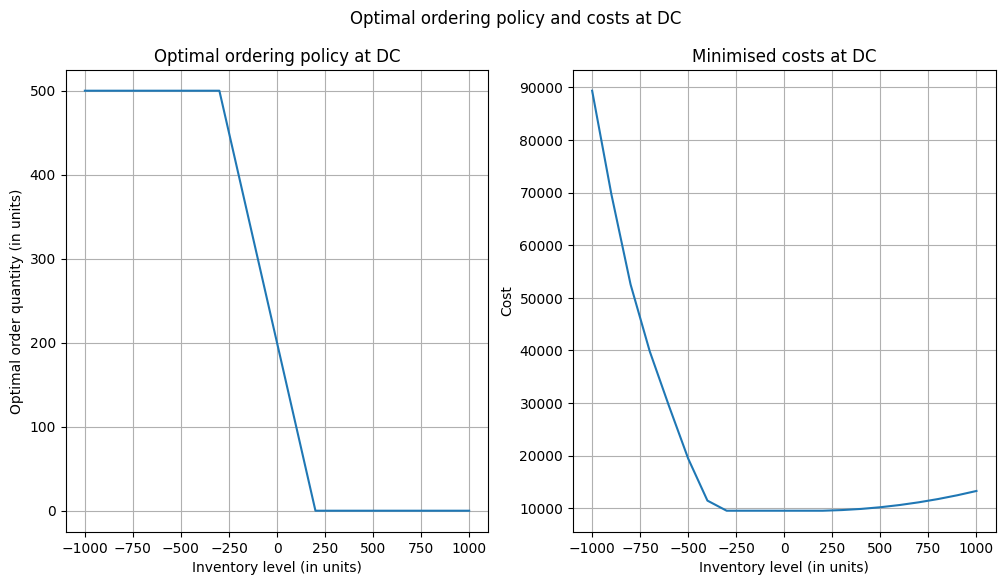

In [4]:
fig, ax = plt.subplots(1, 2, figsize=(12,6))
ax[0].plot(*zip(*sorted(optimal_policy.items())))
ax[0].set(title="Optimal ordering policy at DC", xlabel="Inventory level (in units)", 
ylabel = "Optimal order quantity (in units)")
ax[0].grid()
ax[1].plot(*zip(*sorted(cost_function.items())))
ax[1].set(title="Minimised costs at DC", xlabel="Inventory level (in units)", 
ylabel = "Cost")
ax[1].grid()
plt.suptitle("Optimal ordering policy and costs at DC")
plt.show()

# Implementing Value Iteration to solve 2-echelon inventory optimisation MDP with lead times

In [5]:
def create_lead_P(demand_distribution):
    def prob_trans(s, a, sp):
        prob = 0
        if sp[1:] == (a,) + s[1:-1]: # check updated orders yet to arrive in new state
            demand = s[0] + s[-1] - sp[0]  # demand in time period
            prob = demand_distribution.get(demand, 0) 
        
        return prob
    
    return prob_trans

def create_lead_R(demand_distribution, hold_cost, backlog_cost, order_cost):
    def cost_function(s, a):
        holding_cost = hold_cost*(sum(max(s[0] + s[-1] - dt, 0)*prob for dt, prob in demand_distribution.items()))
        backlogged_cost = backlog_cost*(sum(max(dt - s[0] - s[-1], 0)*prob for dt, prob in demand_distribution.items()))
        ordering_cost = order_cost*a

        return holding_cost + backlogged_cost + ordering_cost
    
    return cost_function


def lead_value_update_func(capacity):
    def bellman_eq_lead(s, S, A, P, R, gamma, Vk):
        values = dict((a, 0) for a in A if sum(s)+a <= capacity)
        if not values:
            values = {0: 0}
        for a in values.keys():
            values[a] = R(s, a) + gamma*sum([P(s, a, sp)*Vk[sp] for sp in S])
        # print(s, values)
        return values
    return bellman_eq_lead

In [6]:
# P((10, 5, 5), 0, (15, 0, 5))

In [7]:
capacity = 10
order_set = set(int(x) for x in np.arange(0, math.ceil(capacity/2)+1, 1))        # set of possible order quantities
inventory_set = set(int(x) for x in np.arange(-capacity, capacity + 1, 1))       # set of possible inventory levels
lead_time = 2                                                                     # lead time

S = set((inv, *arriving_order) for inv in inventory_set for arriving_order in itertools.product(order_set, repeat=lead_time))
A = order_set
demand_dist = {0: 0.2, 1: 0.6, 2: 0.2}
ch = 1
cb = 100
cs = 0
P = create_lead_P(demand_dist)
R = create_lead_R(demand_dist, ch, cb, cs)
V_init = dict([(s, 0) for s in S])    # initial cost is 0 for all states
gamma=1
bellman_eq_lead = lead_value_update_func(capacity)

lead_results= value_iteration(S=S, A=A, P=P, R=R, gamma=0.999, max_iterations=100, 
                          bellman_eq=bellman_eq_lead, V_init=V_init, theta=1e-7)

lead_optimal_policy = lead_results["optimal_policy"]
lead_cost_function = lead_results["value_function"]

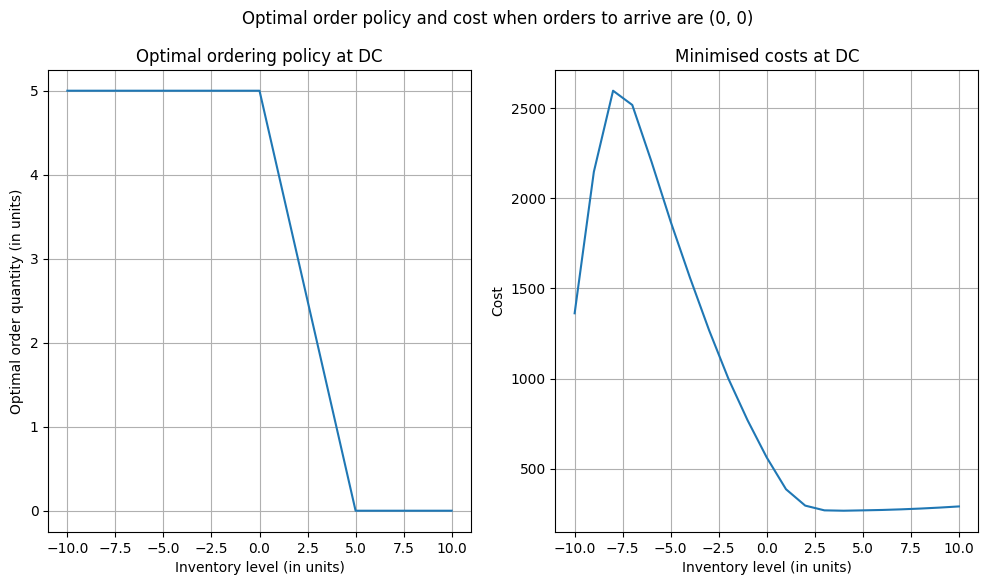

In [8]:
possible_lead_orders = set(itertools.product(order_set, repeat=lead_time))


def plot_per_lead_order(optimal_policy, cost_function, possible_lead_order):
    # If inventory level = x_t + q_{t-L}
    # eligible_keys = [key for key in sorted(optimal_policy) if key[1:-1] == possible_lead_order]
    # inv_levels = [key[0]+key[-1] for key in eligible_keys]
    # opt_policy = [optimal_policy[key] for key in eligible_keys]
    # opt_cost = [cost_function[key] for key in eligible_keys]

    # If inventory level = x_t
    eligible_keys = [key for key in sorted(optimal_policy) if key[1:] == possible_lead_order]
    inv_levels = [key[0] for key in eligible_keys]
    opt_policy = [optimal_policy[key] for key in eligible_keys]
    opt_cost = [cost_function[key] for key in eligible_keys]

    fig, ax = plt.subplots(1,2, figsize=(12,6))
    ax[0].plot(inv_levels, opt_policy)
    ax[0].set(title = "Optimal ordering policy at DC", xlabel="Inventory level (in units)", ylabel="Optimal order quantity (in units)")
    ax[0].grid()
    ax[1].plot(inv_levels, opt_cost)
    ax[1].set(title = "Minimised costs at DC", xlabel="Inventory level (in units)", ylabel="Cost")
    ax[1].grid()
    plt.suptitle(f"Optimal order policy and cost when orders to arrive are {possible_lead_order}")
    plt.show()

plot_per_lead_order(lead_optimal_policy, lead_cost_function, (0,0))
    

In [9]:
# Check all states with same inventory positions have the same order quantity and maybe cost?

In [10]:
inventory_positions = set(sum(key) for key in lead_optimal_policy)
opt_policy_range = dict([(k, 0) for k in inventory_positions])
opt_cost_range = dict([(k, set()) for k in inventory_positions])
for inv_pos in inventory_positions:
    for key, policy in lead_optimal_policy.items():
        if sum(key) == inv_pos:
            # opt_policy_range[inv_pos].add(policy)
            opt_policy_range[inv_pos] = policy
    for key, cost in lead_cost_function.items():
        if sum(key) == inv_pos:
            opt_cost_range[inv_pos].add(cost)

# for inv_pos, policy in opt_policy_range.items():
#     if len(policy) != 1:
#         print(inv_pos, policy)

for inv_pos, cost in opt_cost_range.items():
    if len(cost) != 1:
        print(inv_pos, cost)

0 {961.5304589047049, 1061.530458904705, 561.5304589047049, 661.5304589047049, 761.5304589047049, 861.5304589047049}
1 {865.666418904705, 385.866418904705, 465.666418904705, 565.666418904705, 665.666418904705, 765.666418904705}
2 {295.0181389047049, 394.0181389047049, 494.0181389047049, 594.018138904705, 694.018138904705, 314.2181389047049}
3 {267.765418904705, 268.765418904705, 366.765418904705, 466.765418904705, 566.765418904705, 286.96541890470496}
4 {264.72845890470495, 265.72845890470495, 266.72845890470495, 363.72845890470495, 463.72845890470495, 283.92845890470494}
5 {265.7274589047049, 266.7274589047049, 267.7274589047049, 364.7274589047049, 268.7274589047049, 284.9274589047049}
6 {266.9659192796112, 267.9659192796113, 268.9659192796112, 269.9659192796112, 270.9659192796113, 286.1659192796113}
7 {269.3914795754358, 270.3914795754358, 271.3914795754358, 272.3914795754358, 273.3914795754358, 274.3914795754358}
8 {273.76604246499284, 274.76604246499284, 275.76604246499284, 276.766

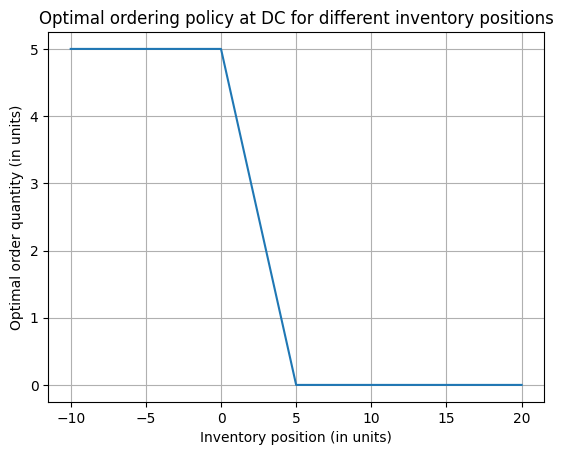

In [11]:
plt.plot(*zip(*sorted(opt_policy_range.items())))
plt.title("Optimal ordering policy at DC for different inventory positions")
plt.xlabel("Inventory position (in units)")
plt.ylabel("Optimal order quantity (in units)")
plt.grid()
plt.show()

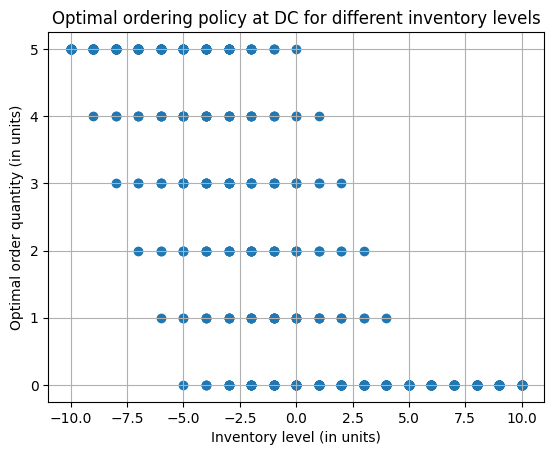

In [12]:
sorted_policy = sorted(lead_optimal_policy.items(), key=lambda item: item[0][0])
inv_levels = [k[0] for k, v in sorted_policy]
opt_order_quantity = [v for k, v in sorted_policy]
plt.scatter(inv_levels, opt_order_quantity)
plt.title("Optimal ordering policy at DC for different inventory levels")
plt.xlabel("Inventory level (in units)")
plt.ylabel("Optimal order quantity (in units)")
plt.grid()
plt.show()

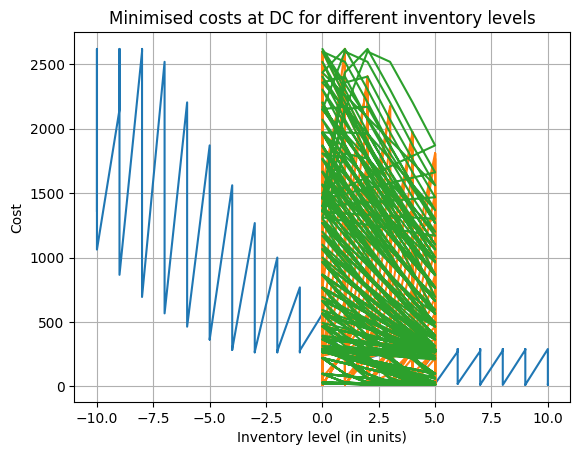

In [13]:
plt.plot(*zip(*sorted(lead_cost_function.items())))
plt.title("Minimised costs at DC for different inventory levels")
plt.xlabel("Inventory level (in units)")
plt.ylabel("Cost")
plt.grid()
plt.show()

In [40]:

inventory_positions = set(sum(state) for state in S)

# Store the different policies and costs for each inventory position
opt_policies_ip = dict([(ip, []) for ip in inventory_positions])
opt_costs_ip = dict([(ip, []) for ip in inventory_positions])

for inv_pos in inventory_positions: # for each inventory position
    for key, policy in lead_optimal_policy.items():
        if sum(key) == inv_pos:
            opt_policies_ip[inv_pos].append(policy)
    for key, cost in lead_cost_function.items():
        if sum(key) == inv_pos:
            opt_costs_ip[inv_pos].append(cost)

opt_policies_ip_unique = dict([(key, set(value)) for key, value in opt_policies_ip.items()])
opt_costs_ip_unique = dict([(key, set(value)) for key, value in opt_costs_ip.items()])


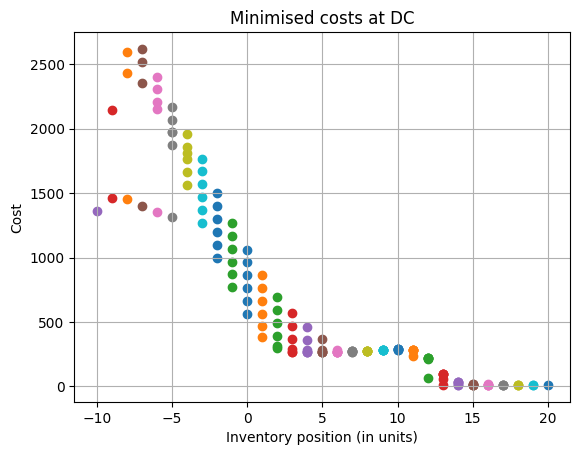

In [39]:
for key, values in opt_costs_ip_unique.items():
    plt.scatter([key]*len(values), list(values))
plt.title("Minimised costs at DC")
plt.xlabel("Inventory position (in units)")
plt.ylabel("Cost")
plt.grid()
plt.show()

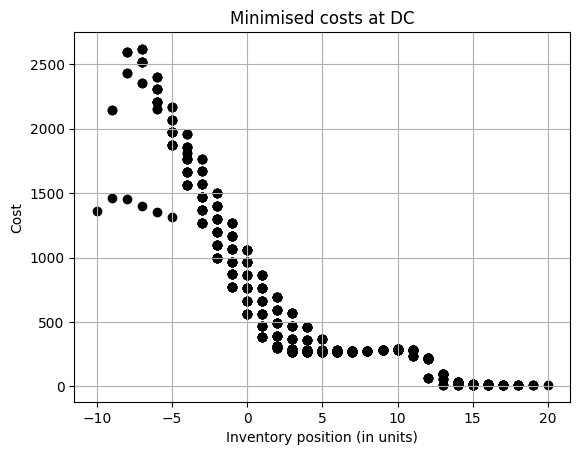

In [27]:
fig, ax = plt.subplots()
for i, (key, values) in enumerate(opt_costs_ip.items()):
    plt.scatter([key] * len(values), values, color='k')  # x is repeated key label

plt.title("Minimised costs at DC")
plt.xlabel("Inventory position (in units)")
plt.ylabel("Cost")
plt.grid()
plt.show()

/tmp/ipykernel_1778099/4030238700.py:3: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(sorted_values_costs, labels=sorted_keys_costs)


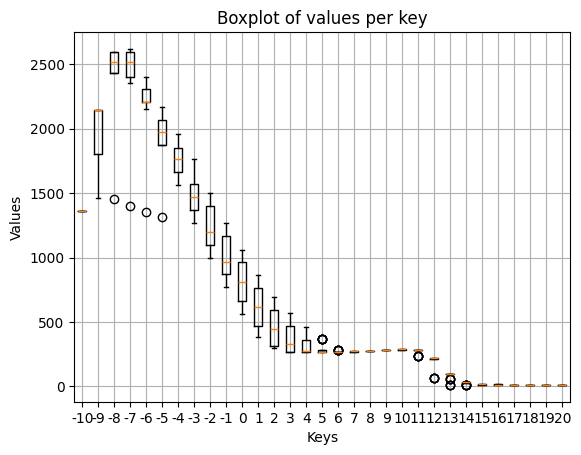

In [ ]:
sorted_keys_costs =  sorted(opt_costs_ip.keys())
sorted_values_costs = [opt_costs_ip[k] for k in sorted_keys_costs]
plt.boxplot(sorted_values_costs, labels=sorted_keys_costs)
plt.title("Boxplot of minimised costs at DC")
plt.xlabel("Inventory position (in units)")
plt.ylabel("Cost")
plt.grid()
plt.show()